In [19]:
# === CONFIG: edit these only (keep distances in METERS) =======================

INPUT      = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\Kobold_Takehome_Assignment_Data\BedrockP.gpkg" # Bedrock polygons (GeoPackage)
OUT_TIF    = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\heatmap_cobalt.tif"  # eoTIFF output – GIS-ready raster (score 0–1).
OUT_PNG    = r"D:\DS_kokold\DS_Kobold_Takehome_Assignment_Data\heatmap_cobalt.png"  # PNG preview – quick map image

# --- Lithology patterns -----------------------------------------------
PATTERN_A  = r"ultramafic|serpentin\w*|dunite|harzburgite|peridotite|komatiite|ophiolite"  # ultramafiques ≈ serpentinite
# Group A: ultramafic/serpentinite keywords (‘|’ = OR, ‘\w*’ = any ending).

PATTERN_B  = r"granodior\w*"  # granodiorite / granodioritic
# Group B: granodiorite keywords (matches “granodiorite/granodioritic”).

RES_M      = 250        # Grid cell size in meters for the heat map. Smaller cell => finer detail, but heavier computation and larger files. 


DECAY_M    = 10000      # DECAY_M defines how far a rock influences the score: value 1 at contact, decreasing gradually to 0 at DECAY_M. 
#Larger values create a more regional effect, smaller values a more local effect.

CRS_EPSG   = 26910      # EPSG code of a PROJECTED CRS in meters.

LAND_PATH  = None  # Optional polygon layer representing land (to mask out ocean areas). Leave as None to skip masking.

# Columns scanned for Group A patterns (broader search). Use fields that contain
# lithology / formation / unit descriptions.
TEXT_COLS_ALL = ("rock_class","rock_type","unit_desc","strat_name","gp_suite","fm_lithodm","mem_phase")
TEXT_COLS_B   = ("rock_class","rock_type","unit_desc","strat_name") # Columns scanned for Group B (granodiorite). Often these four are sufficient.

NODATA_VAL = -9999.0

In [22]:
# ===========================================
# Fast Proximity Heatmap (EDT, linear + product only)
# ===========================================
# Dependencies: geopandas, rasterio, numpy, matplotlib, shapely, scipy

import re
import numpy as np
import geopandas as gpd
import rasterio
from rasterio.transform import from_origin
from rasterio.features import rasterize
from shapely.ops import unary_union
import matplotlib.pyplot as plt

try:
    from scipy.ndimage import distance_transform_edt
except Exception as e:
    raise ImportError(
        "SciPy is required for the distance transform. Please install with: pip install scipy"
    ) from e


# -----------------------
# Text normalization utils
# -----------------------
def _norm_series(s):
    """
    Normalize a pandas Series of strings for robust regex matching:
    - lowercases
    - keeps only [a-z0-9 -_/.] and spaces
    - collapses multiple spaces
    Returns a numpy array of normalized strings.
    """
    s = s.fillna("").astype(str).str.lower()
    s = s.str.replace(r"[^a-z0-9\s\-_/\.]", " ", regex=True)
    s = s.str.replace(r"\s+", " ", regex=True).str.strip()
    return s.values


def tag_matches_vectorized(df: gpd.GeoDataFrame, pattern: str, cols) -> np.ndarray:
    """
    Vectorized row-wise regex search across selected text columns.
    Returns: boolean numpy array (True where any column matches).
    """
    missing = [c for c in cols if c not in df.columns]
    for c in missing:
        df[c] = ""
    blob = df[list(cols)].fillna("").astype(str).agg(" ".join, axis=1)
    blob = _norm_series(blob)
    rx = re.compile(pattern)
    return np.fromiter((bool(rx.search(t)) for t in blob), dtype=bool, count=len(blob))


# -----------------------
# Decay & aggregation (kept minimal by request)
# -----------------------
def _decay_linear(d_m: np.ndarray, D: float) -> np.ndarray:
    """Linear decay: f(d) = clip(1 - d/D, 0, 1)."""
    return np.clip(1.0 - (d_m / float(D)), 0.0, 1.0, dtype=np.float64)

def _aggregate_product(fA: np.ndarray, fB: np.ndarray, alpha: float = 1.0, beta: float = 1.0) -> np.ndarray:
    """Weighted product: (fA^alpha) * (fB^beta)."""
    return (np.power(fA, alpha) * np.power(fB, beta)).astype(np.float32)


# ===========================================
# Main, EDT-based heatmap generator (linear+product)
# ===========================================
def make_heatmap(
    input_path: str,
    out_tif: str,
    out_png: str,
    pattern_a: str,
    pattern_b: str,
    res_m: int = 150,
    decay_m: int = 10000,
    crs_epsg: int = 26910,
    text_cols_all=("rock_class","rock_type","unit_desc","strat_name","gp_suite","fm_lithodm","mem_phase"),
    text_cols_b=("rock_class","rock_type","unit_desc","strat_name"),
    nodata_val: float = -9999.0,
    # kept options
    alpha: float = 1.0,   # weight for Group A
    beta: float = 1.0,    # weight for Group B
    show: bool = True,    # show PNG in notebook
):
    """
    Generate a proximity heatmap using rasterization + Euclidean Distance Transform (EDT).
    Uses linear decay and product aggregation only (per request).

    Steps:
      1) Read & reproject (fix invalid geometries).
      2) Vectorized regex tagging for Groups A and B.
      3) Rasterize A and B masks on a grid (res_m).
      4) EDT to get distance-to-A and distance-to-B (meters).
      5) Linear decay to fA, fB in [0,1]; weighted product aggregation.
      6) Write GeoTIFF and PNG; return summary dict.
    """
    # 1) Read & reproject
    gdf = gpd.read_file(input_path)
    if gdf.empty:
        raise RuntimeError("The input file is empty or unreadable.")
    if gdf.crs is None or gdf.crs.to_epsg() != crs_epsg:
        gdf = gdf.to_crs(crs_epsg)

    if not gdf.geometry.is_valid.all():
        bad = ~gdf.geometry.is_valid
        gdf.loc[bad, "geometry"] = gdf.loc[bad, "geometry"].buffer(0)

    # 2) Tagging (vectorized)
    tags_a = tag_matches_vectorized(gdf, pattern_a, text_cols_all)
    tags_b = tag_matches_vectorized(gdf, pattern_b, text_cols_b)
    if not tags_a.any():
        raise RuntimeError("No features match PATTERN_A. Adjust the pattern.")
    if not tags_b.any():
        raise RuntimeError("No features match PATTERN_B. Adjust the pattern.")

    geom_a = gdf.loc[tags_a, "geometry"]
    geom_b = gdf.loc[tags_b, "geometry"]

    # 3) Optional union (helps reduce slivers before rasterization)
    union_a = unary_union(geom_a.buffer(0))
    union_b = unary_union(geom_b.buffer(0))

    # 4) Grid / transform
    minx, miny, maxx, maxy = gdf.total_bounds
    width  = int(np.ceil((maxx - minx) / res_m))
    height = int(np.ceil((maxy - miny) / res_m))
    if width <= 0 or height <= 0:
        raise RuntimeError("Empty grid. Check the extent or resolution.")
    transform = from_origin(minx, maxy, res_m, res_m)

    # Rasterize A & B
    shapes_a = [(union_a, 1)] if not union_a.is_empty else []
    shapes_b = [(union_b, 1)] if not union_b.is_empty else []
    if not shapes_a:
        raise RuntimeError("Rasterization for Group A produced no shapes.")
    if not shapes_b:
        raise RuntimeError("Rasterization for Group B produced no shapes.")

    mask_a = rasterize(
        shapes=shapes_a,
        out_shape=(height, width),
        transform=transform,
        fill=0, dtype="uint8", all_touched=False
    )
    mask_b = rasterize(
        shapes=shapes_b,
        out_shape=(height, width),
        transform=transform,
        fill=0, dtype="uint8", all_touched=False
    )

    # 5) EDT distances (pixels → meters)
    distA_px = distance_transform_edt(1 - mask_a)
    distB_px = distance_transform_edt(1 - mask_b)
    distA_m  = distA_px * float(res_m)
    distB_m  = distB_px * float(res_m)

    # Linear decay → fA, fB ∈ [0,1]
    fA = _decay_linear(distA_m, decay_m)
    fB = _decay_linear(distB_m, decay_m)

    # Product aggregation (with weights)
    scores = _aggregate_product(fA, fB, alpha=alpha, beta=beta)

    # 6) Write GeoTIFF
    outarr = np.where(np.isnan(scores), nodata_val, scores).astype(np.float32)
    with rasterio.open(
        out_tif, "w",
        driver="GTiff",
        height=height, width=width, count=1,
        dtype=outarr.dtype,
        crs=f"EPSG:{crs_epsg}",
        transform=transform,
        compress="lzw",
        nodata=nodata_val
    ) as dst:
        dst.write(outarr, 1)

    # PNG preview
    fig, ax = plt.subplots(figsize=(8, 8))
    extent = (minx, maxx, miny, maxy)
    im = ax.imshow(scores, origin="upper", extent=extent, vmin=0, vmax=1)
    plt.colorbar(im, ax=ax, label="Score (0–1)")
    try:
        gdf.boundary.plot(ax=ax, linewidth=0.2, color="white")
    except Exception as e:
        print("Contours not plotted:", e)
    ax.set_xlim(minx, maxx); ax.set_ylim(miny, maxy)
    ax.set_aspect("equal")
    ax.set_title("Proximity score (A×B) — linear decay, agg=product")
    ax.set_xticks([]); ax.set_yticks([])
    fig.tight_layout()
    fig.savefig(out_png, dpi=200)
    if show:
        plt.show()
    plt.close(fig)

    # Summary
    return {
        "grid": (width, height),
        "resolution_m": int(res_m),
        "decay": "linear",
        "decay_m": float(decay_m),
        "aggregation": "product",
        "alpha": float(alpha),
        "beta": float(beta),
        "crs": int(crs_epsg),
        "min_score": float(np.nanmin(scores)),
        "max_score": float(np.nanmax(scores)),
        "out_tif": out_tif,
        "out_png": out_png,
    }


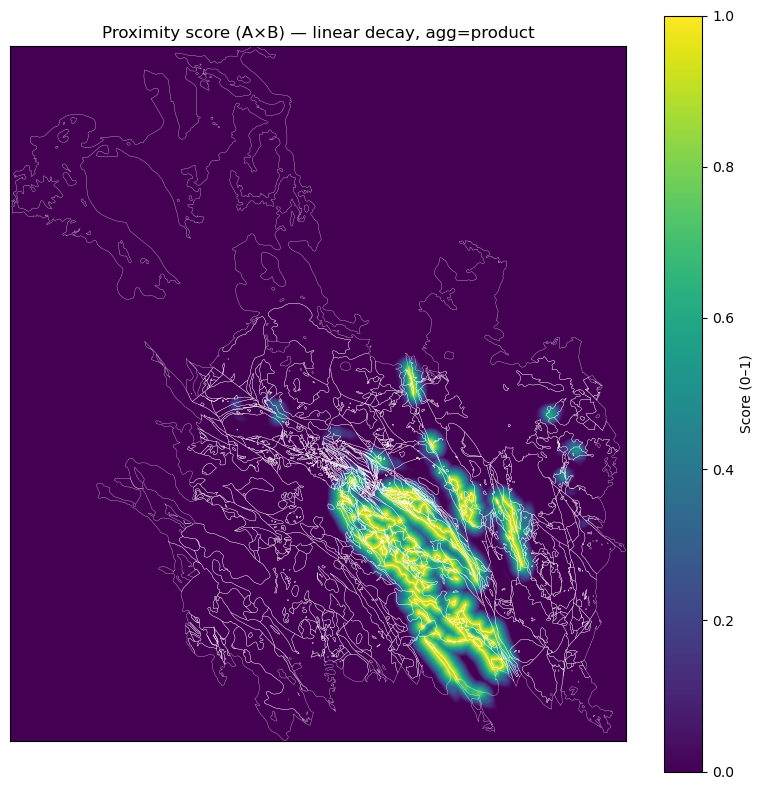

In [24]:
summary = make_heatmap(
    input_path=INPUT,
    out_tif=OUT_TIF,
    out_png=OUT_PNG,
    pattern_a=PATTERN_A,
    pattern_b=PATTERN_B,
    res_m=RES_M,
    decay_m=DECAY_M,
    crs_epsg=CRS_EPSG,
    text_cols_all=TEXT_COLS_ALL,
    text_cols_b=TEXT_COLS_B,
    nodata_val=NODATA_VAL,
    alpha=1.0,   # poids A
    beta=1.0,    # poids B
    show=True    # affiche la carte dans le notebook
)
